In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.ldamodel import LdaModel
from data_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 

print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [5]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [6]:
y_train, y_val = label_encoder(y_train, y_val)

In [7]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [8]:
pad_len=100
padding_type='post'
truncating_type='post'

In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index
len(vocab.keys())

52575

# Domain Specific Fasttext Embeddings

In [14]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

51245
Total time taken:  4.788258341000001


(52576, 300)

In [15]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  52576
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# LDA Embeddings

In [16]:
LDA_model = LdaModel.load("/home/eastwind/word-embeddings/LDA/Normal/TechDofication.LDA.normal.raw.t12")

29684
Total time taken:  11.465761646999999


(52576, 300)

In [17]:
start = process_time()
X_train_LDA =prepare_LDA_input(training_data.text.values.tolist(), LDA_model)
X_val_LDA =prepare_LDA_input(val_data.text.values.tolist(), LDA_model)
end = process_time()
print("Total time taken: ", end-start)
print(X_train_LDA.shape)
print(X_val_LDA.shape)

Input dimension 2:  52576
Embedding dimensions 2:  300
Input sentence dimensions 2:  100


In [ ]:
input_len2 = X_train_LDA.shape[1]
print("LDA input shape: ", input_len2)

# Domain Specific + LDA Multi-channel CNN Architecture

In [55]:
# Input 1(Domain Specific Fasttext Embeddings):
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, output_dim=embedding_dim1, weights=[embedding_matrix1], trainable=False)(Input1)
LSTM1 = Bidirectional(LSTM(64, dropout=0.3, return_sequences=True))(Embedding_layer1)
Conv1 = Conv1D(32, kernel_size=5, activation='relu')(LSTM1)
max_pooling1 = MaxPooling1D(pool_size=3)(Conv1)
Flatten1 = Flatten()(max_pooling1)
Dense1 = Dense(512, activation='relu')(Flatten1)
Dropout2 = Dropout(0.3)(Dense1)
Dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.015))(Dropout2)

# Input 2 (LDA doc embedding):
Input3 = Input(shape=(input_len2,))
Dense3 = Dense(4, activation='relu')(Input3)
Dropout_out = Dropout(0.1)(Dense3)
Merged = concatenate([Dense2, Dropout_out])
output = Dense(4, activation='softmax')(Merged)

classifier2 = Model(inputs=[Input1, Input3], outputs=output)
classifier2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 100, 300)     15772800    input_14[0][0]                   
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 100, 128)     186880      embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 96, 32)       20512       bidirectional_5[0][0]            
____________________________________________________________________________________________

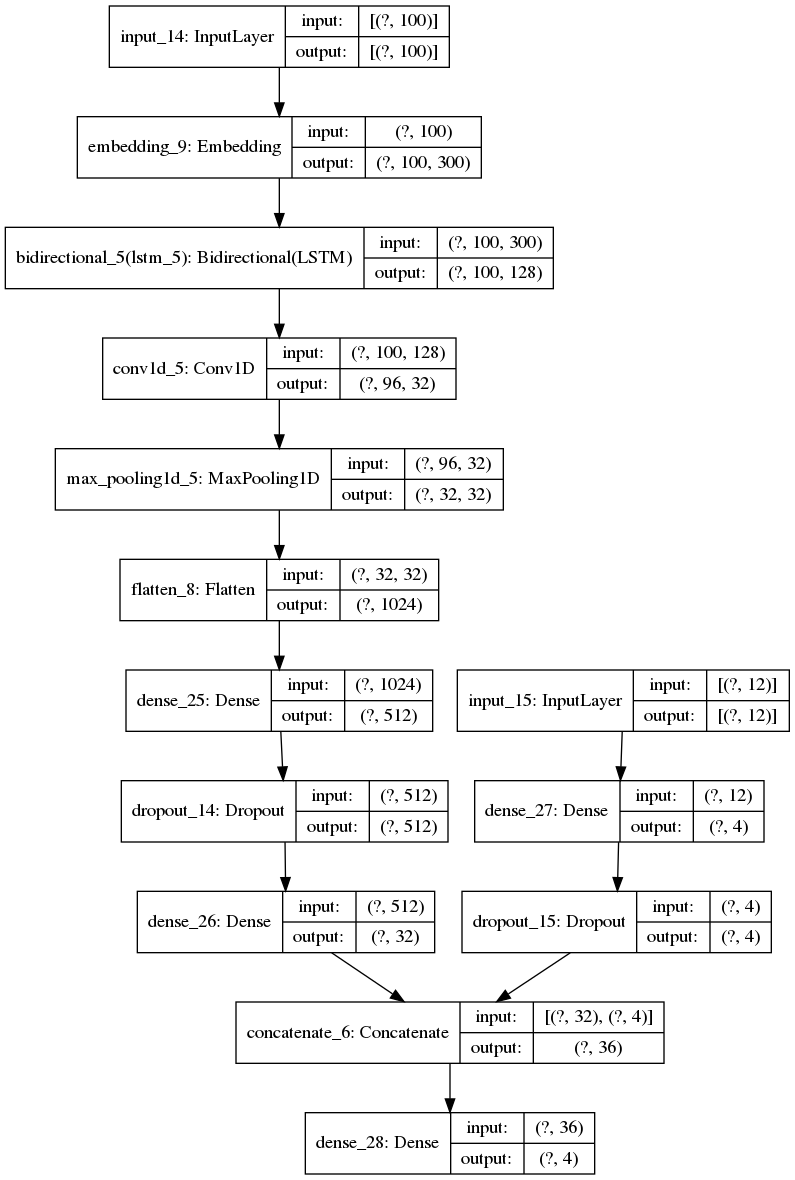

In [56]:
plot_model(classifier2, show_shapes=True, to_file='multichannel.png')

In [57]:
history2 = classifier2.fit([x_train_padded, X_train_LDA], 
                            y_train, 
                            epochs=8,
                            batch_size=128,
                            verbose=1,
                            validation_data=([x_val_padded, X_val_LDA], y_val))

Epoch 1/8
329/329 [==============================] - 137s 416ms/step - loss: 0.6767 - acc: 0.7974 - val_loss: 0.4215 - val_acc: 0.8640
Epoch 2/8
329/329 [==============================] - 117s 355ms/step - loss: 0.4165 - acc: 0.8537 - val_loss: 0.3779 - val_acc: 0.8683
Epoch 3/8
329/329 [==============================] - 119s 362ms/step - loss: 0.3770 - acc: 0.8675 - val_loss: 0.3747 - val_acc: 0.8717
Epoch 4/8
329/329 [==============================] - 124s 378ms/step - loss: 0.3479 - acc: 0.8772 - val_loss: 0.3543 - val_acc: 0.8783
Epoch 5/8
329/329 [==============================] - 131s 400ms/step - loss: 0.3268 - acc: 0.8857 - val_loss: 0.3674 - val_acc: 0.8685
Epoch 6/8
329/329 [==============================] - 130s 395ms/step - loss: 0.3017 - acc: 0.8941 - val_loss: 0.3774 - val_acc: 0.8704
Epoch 7/8
329/329 [==============================] - 133s 404ms/step - loss: 0.2843 - acc: 0.9013 - val_loss: 0.3433 - val_acc: 0.8820
Epoch 8/8
329/329 [==============================] - 13

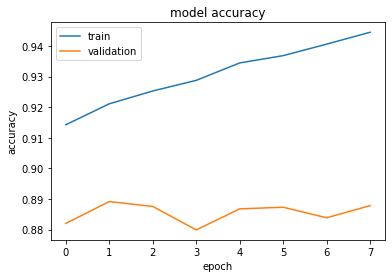

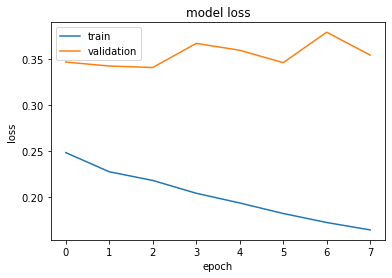

In [64]:
plot_curves(history2)

In [65]:
results2 = np.argmax(classifier2.predict([x_val_padded, X_val_LDA]), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8878306878306879

Precision:  [0.89859155 0.87827715 0.91686183 0.87409701]
Average Precision:  0.8919568841939154

Recall:  [0.75952381 0.93488372 0.88474576 0.87319588]
Average Recall:  0.8630872923636416

F1-Score:  [0.82322581 0.90569681 0.90051754 0.87364621]
Average F1-Score:  0.8757715920749776


In [60]:
save_model(classifier, "multi-channel-1-BiLSTM-CNN-2-LDA-12-f1-8781")